## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


### 1. perform histogram of oriented gradients (HOG) feature extraction on image

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

'''
for .png format image files
matplotlib.imread() will read in to scale 0 to 1.0
cv2.imread() will scale them from 0 to 255. 
'''

%matplotlib inline

#### utility functions for the project

In [13]:
def draw_boxes(img, bboxes, color = (0, 0, 225), thick = 6):
    drawimg = np.copy(img)
    for bbox in bboxes:
        p1, p2 = bbox
        cv2.rectangle(drawimg, p1, p2, color, thick)
    return drawimg

unit test for functiton draw_boxes()

In [20]:
def test_draw_boxes():
    filename = './test_images/test5.jpg'
    img = cv2.imread(filename)
    print('draw boxes on image ', filename, ' with size ', img.shape)
    bboxes = []
    p1, p2 = (40, 40), (126, 217)
    bboxes.append((p1, p2))
    p1, p2 = (0, 0), (1280, 720)
    bboxes.append((p1, p2))
    p1, p2 = (50, 50), (20, 20)
    bboxes.append((p1, p2))
    
    result = draw_boxes(img, bboxes, color = (0, 0, 225), thick = 6)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

draw boxes on image  ./test_images/test5.jpg  with size  (720, 1280, 3)


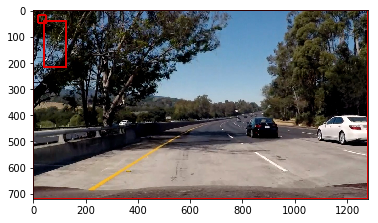

In [21]:
test_draw_boxes()

#### function for template matching

In [28]:
def find_matches(img, template_list):
    # Define an empty list to take bbox coords
    bbox_list = []
    # Define matching method
    # Other options include: cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF', 'cv2.TM_CCORR',
    #         'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED'
    method = cv2.TM_CCOEFF_NORMED
    # Iterate through template list
    for temp in template_list:
        # Read in templates one by one
        tmp = mpimg.imread(temp)
        # Use cv2.matchTemplate() to search the image
        result = cv2.matchTemplate(img, tmp, method)
        # Use cv2.minMaxLoc() to extract the location of the best match
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        # Determine a bounding box for the match
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        bbox_list.append((top_left, bottom_right))
    return bbox_list

In [29]:
import glob
def test_find_matches():
    template_list = glob.glob('./examples/car_templates/*.jpeg')
    filename = './test_images/test5.jpg'
    img = plt.imread(filename)
    bbox_list = find_matches(img, template_list)
    result = draw_boxes(img, bbox_list)
    plt.imshow(result)

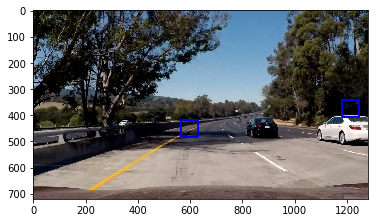

In [31]:
test_find_matches()

we can see that template_maches function doesnt't work well

In [32]:
from skimage.feature import hog
def get_hog_feature(img, orient = 9, pix_per_cell = 8, cell_per_block = 2, vis = False, feature_vec = True):
    if vis == True:
        features, hog_image = hog(img, orientations = orient,
                                 pixels_per_cell = (pix_per_cell, pix_per_cell),
                                 cells_per_block = (cell_per_block, cell_per_block),
                                 visualise = True, feature_vector = feature_vec)
        return features, hog_image
    else:
        features, hog_image = hog(img, orientations = orient, 
                                 pixels_per_cell = (pix_per_cell, pix_per_cell),
                                 cells_per_block = (cell_per_block, cell_per_block),
                                 visualise = False,
                                 feature_vector = feature_vec)
        return features

In [47]:
def test_get_hog_feature(vis = True):
    filename = './examples/car_templates/1.jpeg'
    img = plt.imread(filename)
    channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if vis:
        features, hog_image = get_hog_feature(channel, vis = vis)
        fig = plt.figure()
        plt.subplot(131)
        plt.imshow(img)
        plt.title('raw img')
        plt.subplot(132)
        plt.imshow(channel, cmap='gray')
        plt.title('channel')
        plt.subplot(133)
        plt.imshow(hog_image)
        plt.title('hog img')    

C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


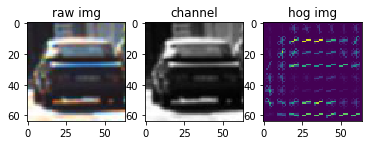

In [48]:
test_get_hog_feature()

In [ ]:
def get_color_histogram(img, nbin = 32, bins_range = (0, 256)):
    # assert img format is 'rgb'
    r_hist = np.histogram(img[:,:,0], bins = nbin, range = bins_range)
    g_hist = np.histogram(img[:,:,1], bins = nbin, rnage = bins_range)
    b_hist = np.histogram(img[:,:,2], bins = nbin, rnage = bins_range)
    bin_center = (r_hist[1][0:-1] + r_hist[1][1:])/2
    hist = np.concatenate((r_hist[0], g_hist[0], b_hist[0]))
    return r_hist, g_hist, b_hist, bin_center, hist

In [3]:
def binning_features(img, color_space = 'rgb', size = (32,32)):
    img2 = cv2.resize(img, size)
    feature = cv2.ravel(img2)
    return feature

In [ ]:
# use the method above to extract features and do the preprocessing
def extract_features(imgfiles, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgfiles:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features



### get data set


In [3]:
import glob
images = glob.glob('*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

car_features = extract_features(cars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

NameError: name 'extract_features' is not defined

In [ ]:
def cross_validation_search():
    parameters = {'kernel': ('linear','rbf'), 'C':[1, 10]}
    svr = svm.SVC()
    clf = grid_search.GridSearchCV(svr, parameters)
    clf.fit(iris.data, iris.target)
    return clf.best_params_


In [ ]:
from sklearn.preprocessing import StandardScaler
def nomalize(img):
    X = np.vstack((car_features,notcar_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    return scaled_X

In [4]:
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    # Compute the span of the region to be searched    
    # Compute the number of pixels per step in x/y
    # Compute the number of windows in x/y
    # Initialize a list to append window positions to
    window_list = []
    x_start, x_stop = x_start_stop
    y_start, y_stop = y_start_stop
    
    if x_start == None: x_start = 0
    if x_stop == None: x_stop = img.shape[1]
    if y_start == None: y_start = 0
    if y_stop == None: y_stop = img.shape[0]
    for x in range(x_start, x_stop, int(xy_window[0] * xy_overlap[0])):
        for y in range(y_start, y_stop, int(xy_window[1] * xy_overlap[1])):
            p1 = (x, y)
            p2 = (x + xy_window[0], y + xy_window[1])
            window_list.append((p1, p2))
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list

In [ ]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [ ]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    

In [5]:
def create_heat_map():
    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    
    def add_heat(heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap


In [ ]:
from scipy.ndimage.measurements import label
labels = label(heatmap)
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [ ]:
from skimage.feature import hog
def extract_wholeimg_hog(img):
    # Extract HOG features just once for the entire region of interest in each full image / video frame
    # The output feature_array will have a shape of (n_yblocks, n_xblocks, 2, 2, 9), 
    # where n_yblocks and n_xblocks are determined by the shape of your region of interest 
    # (i.e. how many blocks fit across and down your image in x and y). 
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    feature_array = hog(img, 
                        orientations=orient, 
                        pixels_per_cell=(pix_per_cell, pix_per_cell), 
                        cells_per_block=(cell_per_block, cell_per_block), 
                        visualise=False, 
                        feature_vector=False)
    return feature_array


In [6]:
def pipeline(img):
    pass


## And so on and so forth...